### Merchandising for Optimal Stocking And Procurement for Better Sourcing

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import numpy as np

#### Data preprocessing

In [5]:
data = pd.read_csv('WalmartSalesData.csv')
data

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,2019-01-29,13:46:00,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,2019-03-02,17:16:00,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2019-02-09,13:22:00,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2019-02-22,15:33:00,Cash,65.82,4.761905,3.2910,4.1


In [6]:
# Convert 'Date' to datetime format and extract day, month, and year for further analysis
data['Date'] = pd.to_datetime(data['Date'])
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

In [7]:
# Convert 'Time' to datetime format and extract hour for further analysis
data['Time'] = pd.to_datetime(data['Time']).dt.time
data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour

/var/folders/z6/r57ddz213j7gnxkkgzlfr3d00000gn/T/ipykernel_14290/1971674104.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['Time']).dt.time


In [8]:
# Analyze sales patterns by Product Line to suggest optimal stocking levels
product_sales = data.groupby('Product line').agg({'Quantity': 'sum', 'Total': 'sum'}).sort_values(by='Quantity', ascending=False)

# Adding average quantity sold per transaction for each product line
product_sales['Avg Quantity per Transaction'] = product_sales['Quantity'] / data['Product line'].value_counts()

print("Product Sales Analysis:")
print(product_sales)

Product Sales Analysis:
                        Quantity       Total  Avg Quantity per Transaction
Product line                                                              
Electronic accessories       971  54337.5315                      5.711765
Food and beverages           952  56144.8440                      5.471264
Sports and travel            920  55122.8265                      5.542169
Home and lifestyle           911  53861.9130                      5.693750
Fashion accessories          902  54305.8950                      5.067416
Health and beauty            854  49193.7390                      5.618421


In [9]:
# Analyzing sales trends over time to guide procurement strategies
# Grouping data by Month and Product Line
monthly_sales = data.groupby(['Month', 'Product line']).agg({'Quantity': 'sum', 'Total': 'sum'}).unstack().fillna(0)

print("\nMonthly Sales Trends:")
print(monthly_sales)


Monthly Sales Trends:
                           Quantity                                         \
Product line Electronic accessories Fashion accessories Food and beverages   
Month                                                                        
1                               333                 336                325   
2                               313                 295                349   
3                               325                 271                278   

                                                                     \
Product line Health and beauty Home and lifestyle Sports and travel   
Month                                                                 
1                          254                342               375   
2                          266                205               226   
3                          334                364               319   

                              Total                                         \
Pro

## Ensuring timely availability of products 

#### Analysing data for Hourly sales for better avalibality of product at any time of a day.

In [12]:
# Analyzing peak sales periods by time and product line
hourly_sales = data.groupby(['Hour', 'Product line']).agg({'Quantity': 'sum'}).unstack().fillna(0)

<Figure size 1400x800 with 0 Axes>

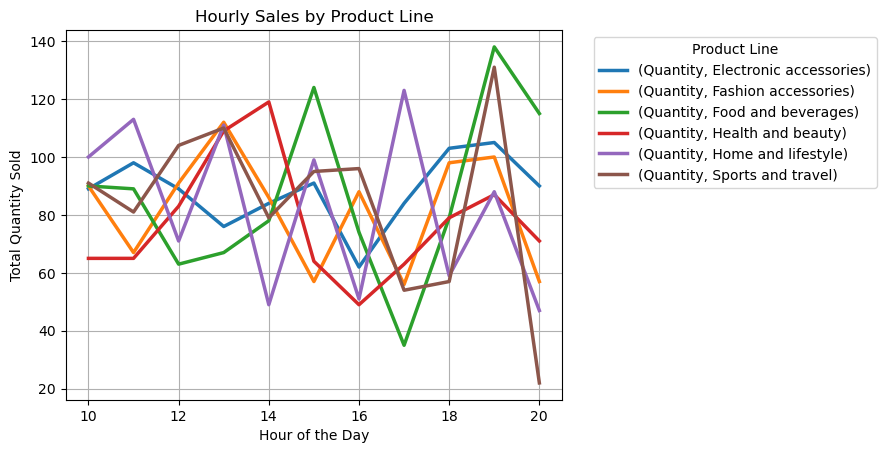

In [13]:
# Plotting the hourly sales for each product line to visualize peak demand times
plt.figure(figsize=(14, 8))
hourly_sales.plot(kind='line', linewidth=2.5)
plt.title('Hourly Sales by Product Line')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.legend(title='Product Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [14]:
# Analyze sales by day of the week to identify peak demand periods
data['DayOfWeek'] = data['Date'].dt.dayofweek
daily_sales = data.groupby(['DayOfWeek', 'Product line']).agg({'Quantity': 'sum'}).unstack().fillna(0)

#### Analysing data for weekly sales for better avalibality of product for all days in a month

<Figure size 1400x800 with 0 Axes>

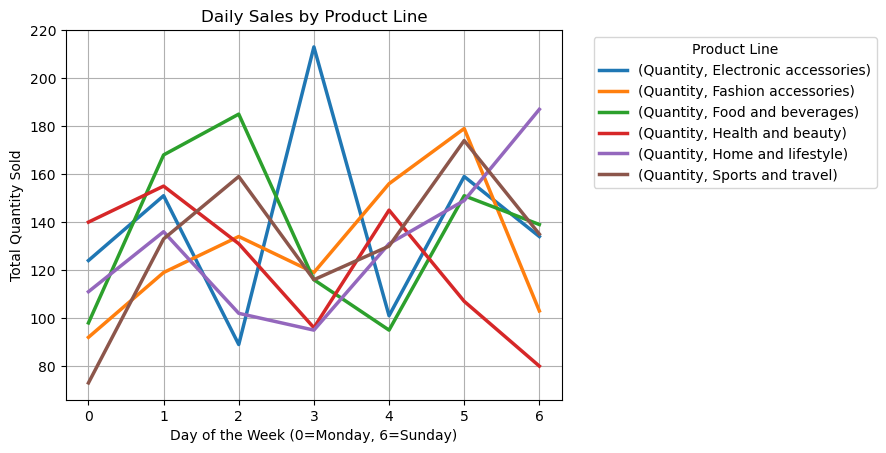

In [16]:
# Plotting the daily sales for each product line
plt.figure(figsize=(14, 8))
daily_sales.plot(kind='line', linewidth=2.5)
plt.title('Daily Sales by Product Line')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.legend(title='Product Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Doing time series forecast for ensuring the better availbliblity of the product in fucture

In [18]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Ensure 'Quantity' is numeric (convert if necessary)
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')

# Drop rows with missing or invalid quantity values
data = data.dropna(subset=['Quantity'])

# Aggregate the data by Date and Product line to get daily total sales quantity for each product line
product_sales = data.groupby(['Date', 'Product line']).agg({'Quantity': 'sum'}).reset_index()

#### Using ARMIA Model for doing produt avalibality in future

In [20]:
# Function to forecast sales for a given product line
def forecast_sales(product_line, product_sales):
    # Filter data for the specific product line
    product_data = product_sales[product_sales['Product line'] == product_line]
    
    # Set the Date column as the index
    product_data.set_index('Date', inplace=True)
    
    # Resample data to fill missing dates (if any) and handle missing values
    product_data = product_data.resample('D').sum().fillna(0)
    
    # ARIMA model (parameters can be tuned based on ACF and PACF)
    model = ARIMA(product_data['Quantity'], order=  (4,1,3))
    model_fit = model.fit()
    
    # Forecasting
    forecast_steps = 30  # Number of days to forecast
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Plotting the forecast
    plt.figure(figsize=(14, 8))
    plt.plot(product_data['Quantity'], label='Actual Sales')
    plt.plot(forecast.index, forecast, label='Forecasted Sales', color='red')
    plt.title(f'Sales Forecast for {product_line} - Next 30 Days')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print the forecasted values
    print(f"Forecasted Sales for {product_line} in the next 30 days:")
    print(forecast)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


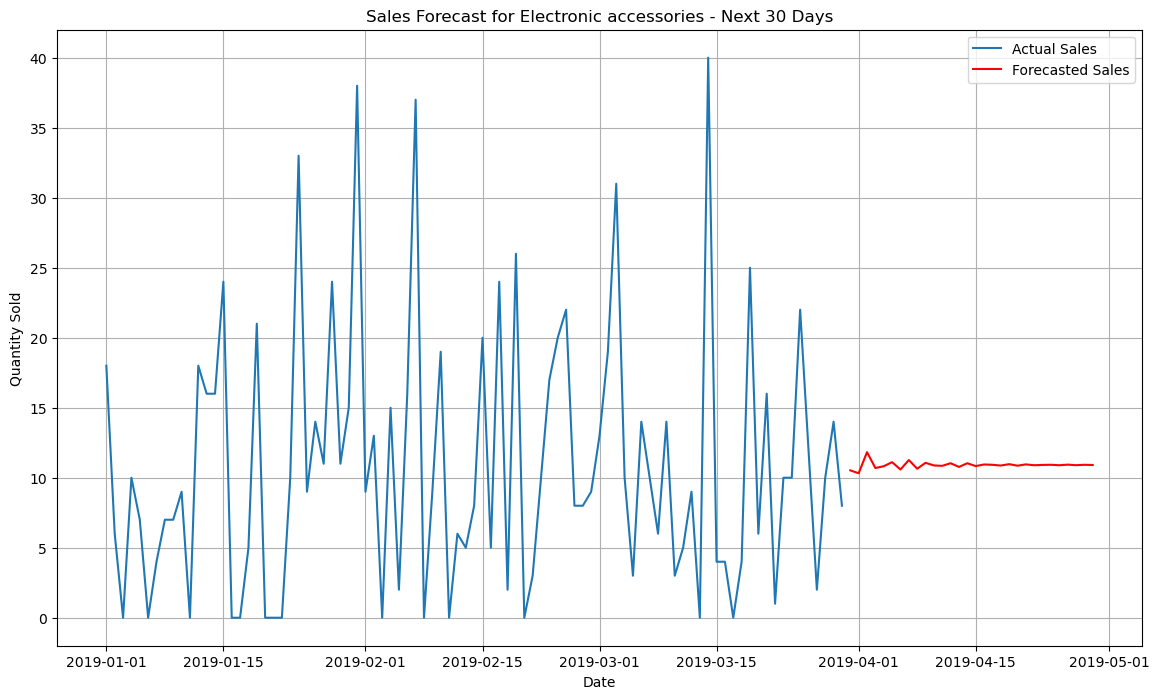

Forecasted Sales for Electronic accessories in the next 30 days:
2019-03-31    10.525387
2019-04-01    10.316996
2019-04-02    11.825846
2019-04-03    10.692251
2019-04-04    10.822386
2019-04-05    11.111146
2019-04-06    10.586938
2019-04-07    11.262485
2019-04-08    10.643933
2019-04-09    11.065317
2019-04-10    10.877166
2019-04-11    10.849322
2019-04-12    11.036082
2019-04-13    10.771683
2019-04-14    11.035030
2019-04-15    10.830983
2019-04-16    10.944970
2019-04-17    10.924250
2019-04-18    10.870158
2019-04-19    10.968477
2019-04-20    10.858791
2019-04-21    10.952576
2019-04-22    10.891673
2019-04-23    10.914248
2019-04-24    10.925552
2019-04-25    10.891271
2019-04-26    10.935201
2019-04-27    10.893804
2019-04-28    10.924063
2019-04-29    10.908934
Freq: D, Name: predicted_mean, dtype: float64


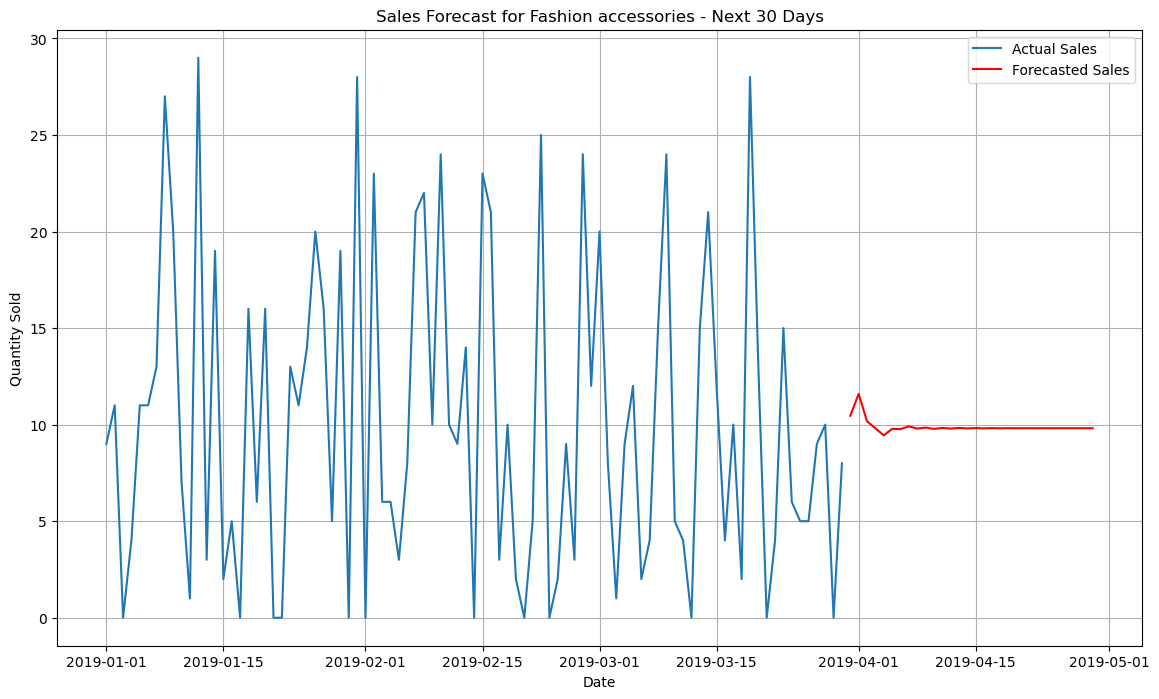

Forecasted Sales for Fashion accessories in the next 30 days:
2019-03-31    10.459550
2019-04-01    11.593119
2019-04-02    10.174371
2019-04-03     9.807284
2019-04-04     9.443581
2019-04-05     9.780194
2019-04-06     9.765785
2019-04-07     9.909710
2019-04-08     9.795980
2019-04-09     9.844164
2019-04-10     9.779729
2019-04-11     9.829204
2019-04-12     9.796670
2019-04-13     9.827666
2019-04-14     9.803563
2019-04-15     9.821724
2019-04-16     9.806250
2019-04-17     9.818454
2019-04-18     9.808857
2019-04-19     9.816717
2019-04-20     9.810465
2019-04-21     9.815447
2019-04-22     9.811425
2019-04-23     9.814637
2019-04-24     9.812067
2019-04-25     9.814131
2019-04-26     9.812480
2019-04-27     9.813803
2019-04-28     9.812742
2019-04-29     9.813591
Freq: D, Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


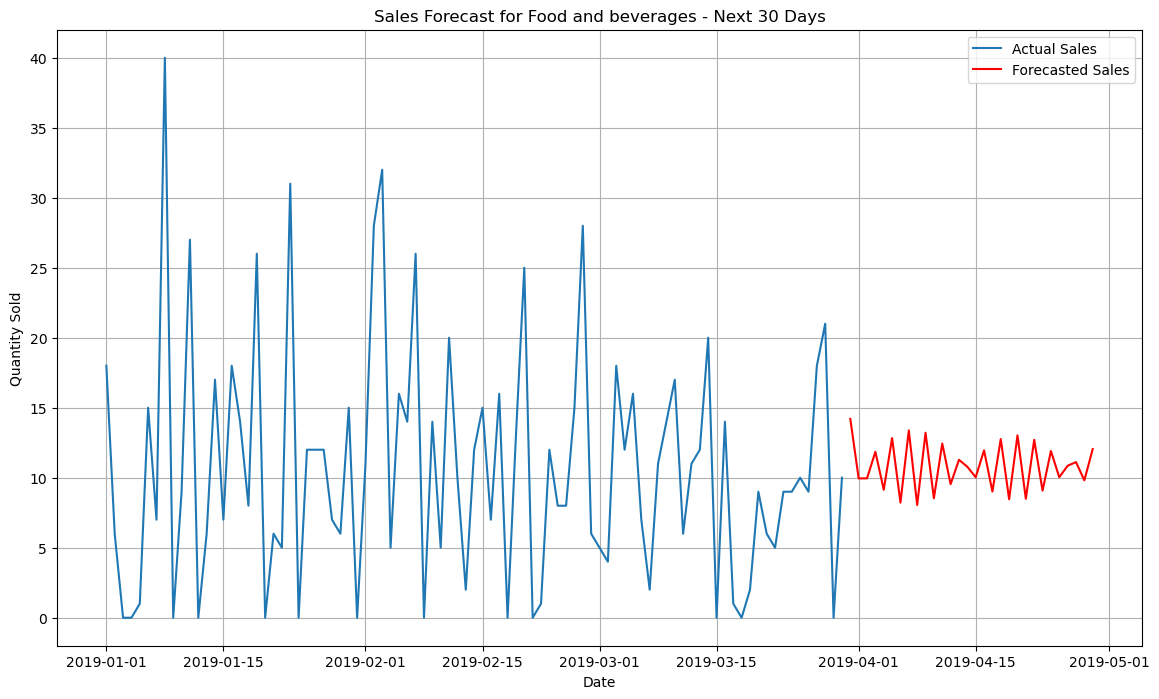

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasted Sales for Food and beverages in the next 30 days:
2019-03-31    14.203856
2019-04-01     9.948793
2019-04-02     9.956168
2019-04-03    11.853490
2019-04-04     9.139582
2019-04-05    12.829929
2019-04-06     8.222254
2019-04-07    13.380895
2019-04-08     8.053812
2019-04-09    13.212958
2019-04-10     8.537747
2019-04-11    12.442552
2019-04-12     9.539716
2019-04-13    11.279894
2019-04-14    10.784949
2019-04-15    10.033009
2019-04-16    11.954198
2019-04-17     9.013972
2019-04-18    12.761771
2019-04-19     8.464170
2019-04-20    13.024999
2019-04-21     8.497402
2019-04-22    12.704518
2019-04-23     9.077865
2019-04-24    11.907226
2019-04-25    10.036071
2019-04-26    10.852919
2019-04-27    11.117104
2019-04-28     9.814576
2019-04-29    12.047720
Freq: D, Name: predicted_mean, dtype: float64


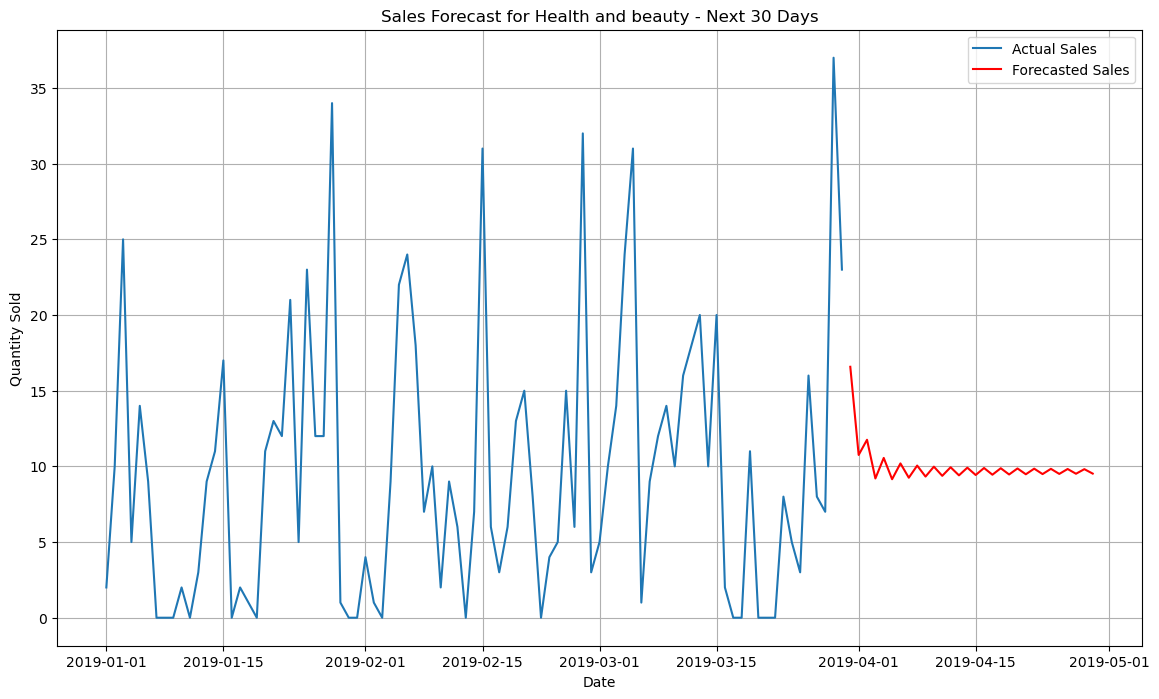

Forecasted Sales for Health and beauty in the next 30 days:
2019-03-31    16.579616
2019-04-01    10.754567
2019-04-02    11.757635
2019-04-03     9.201547
2019-04-04    10.558498
2019-04-05     9.151052
2019-04-06    10.194774
2019-04-07     9.250132
2019-04-08    10.051969
2019-04-09     9.326313
2019-04-10     9.981902
2019-04-11     9.374965
2019-04-12     9.941144
2019-04-13     9.407101
2019-04-14     9.913883
2019-04-15     9.430307
2019-04-16     9.893410
2019-04-17     9.448653
2019-04-18     9.876636
2019-04-19     9.464190
2019-04-20     9.862077
2019-04-21     9.477943
2019-04-22     9.849000
2019-04-23     9.490436
2019-04-24     9.837024
2019-04-25     9.501944
2019-04-26     9.825945
2019-04-27     9.512625
2019-04-28     9.815638
2019-04-29     9.522577
Freq: D, Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


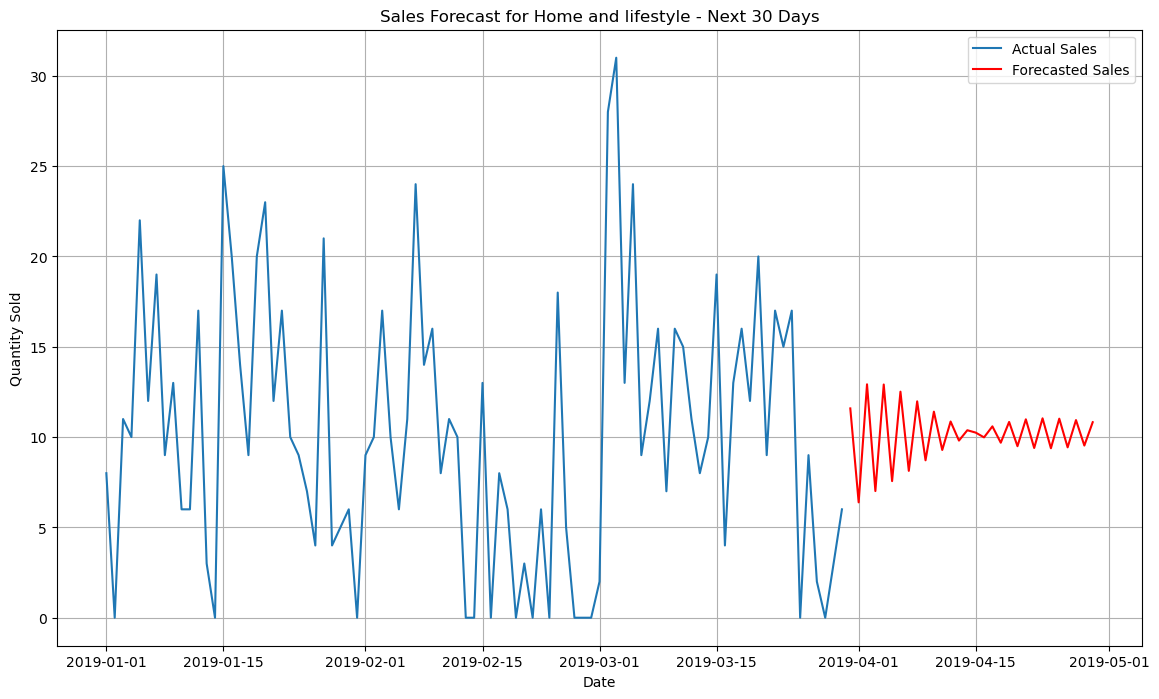

Forecasted Sales for Home and lifestyle in the next 30 days:
2019-03-31    11.587106
2019-04-01     6.386834
2019-04-02    12.921009
2019-04-03     7.012373
2019-04-04    12.909646
2019-04-05     7.563084
2019-04-06    12.513074
2019-04-07     8.129741
2019-04-08    11.978077
2019-04-09     8.715115
2019-04-10    11.407585
2019-04-11     9.285941
2019-04-12    10.861449
2019-04-13     9.806082
2019-04-14    10.378753
2019-04-15    10.247644
2019-04-16     9.983804
2019-04-17    10.593665
2019-04-18     9.688626
2019-04-19    10.837784
2019-04-20     9.494959
2019-04-21    10.982690
2019-04-22     9.396382
2019-04-23    11.038077
2019-04-24     9.380535
2019-04-25    11.018445
2019-04-26     9.431317
2019-04-27    10.940999
2019-04-28     9.530899
2019-04-29    10.823758
Freq: D, Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


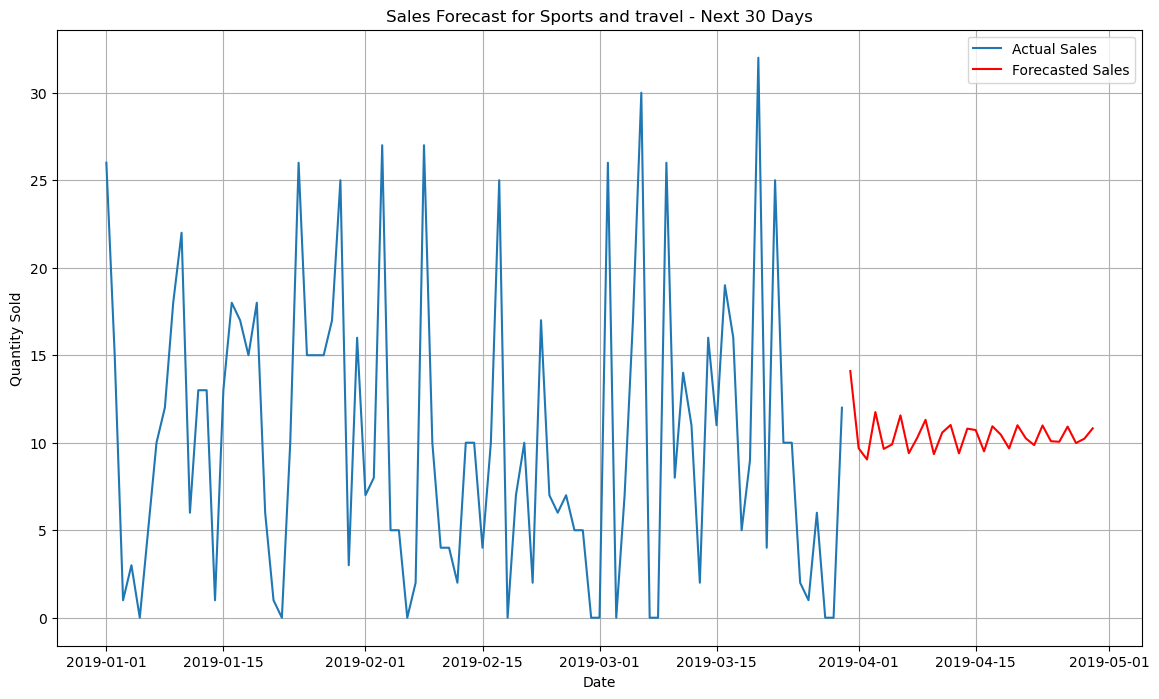

Forecasted Sales for Sports and travel in the next 30 days:
2019-03-31    14.096012
2019-04-01     9.681913
2019-04-02     9.042115
2019-04-03    11.753715
2019-04-04     9.647779
2019-04-05     9.904207
2019-04-06    11.564014
2019-04-07     9.401492
2019-04-08    10.274341
2019-04-09    11.307835
2019-04-10     9.349709
2019-04-11    10.581625
2019-04-12    11.013420
2019-04-13     9.392759
2019-04-14    10.805060
2019-04-15    10.724235
2019-04-16     9.509604
2019-04-17    10.941650
2019-04-18    10.463606
2019-04-19     9.674659
2019-04-20    10.998018
2019-04-21    10.248108
2019-04-22     9.863397
2019-04-23    10.986214
2019-04-24    10.086910
2019-04-25    10.054445
2019-04-26    10.921657
2019-04-27     9.982531
2019-04-28    10.230740
2019-04-29    10.821089
Freq: D, Name: predicted_mean, dtype: float64


In [21]:
# Get unique product lines
product_lines = product_sales['Product line'].unique()

# Forecast for each product line
for product_line in product_lines:
    forecast_sales(product_line, product_sales)

## Optimizing the pricing of products

In [23]:
# Correlation Analysis: Unit price vs. Quantity
correlation = data[['Unit price', 'Quantity']].corr()
print("Correlation between Unit Price and Quantity Sold:")
print(correlation)

Correlation between Unit Price and Quantity Sold:
            Unit price  Quantity
Unit price    1.000000  0.010778
Quantity      0.010778  1.000000


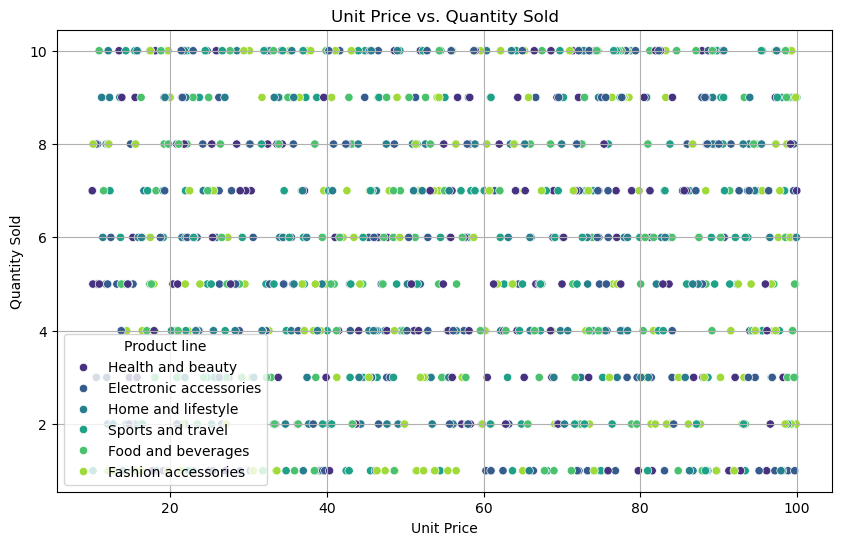

In [24]:
# Scatter plot of Unit price vs. Quantity sold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Unit price', y='Quantity', data=data, hue='Product line', palette='viridis')
plt.title('Unit Price vs. Quantity Sold')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

A scatter plot of Unit price vs. Quantity helps visualize how different product lines behave in terms of pricing. This can show how sensitive customers are to price changes for each product line.

#### Scatter plot of Unit price vs. Revenue

In [27]:
# Calculate Revenue
data['Revenue'] = data['Unit price'] * data['Quantity']

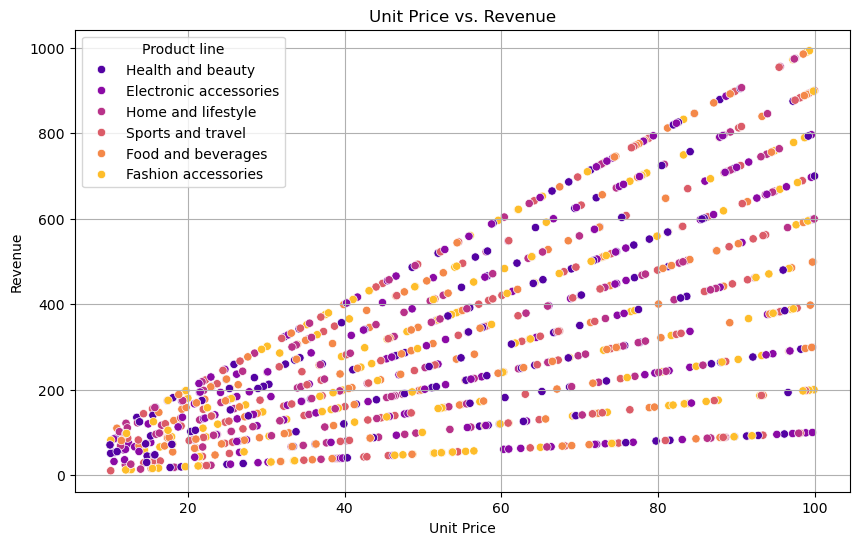

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Unit price', y='Revenue', data=data, hue='Product line', palette='plasma')
plt.title('Unit Price vs. Revenue')
plt.xlabel('Unit Price')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [29]:
# Revenue Optimization: Calculate revenue at different price points
data['Revenue'] = data['Unit price'] * data['Quantity']

# Grouping by Product Line to see the trend within each category
revenue_by_price = data.groupby(['Unit price', 'Product line']).agg({'Revenue': 'sum', 'Quantity': 'sum'}).reset_index()

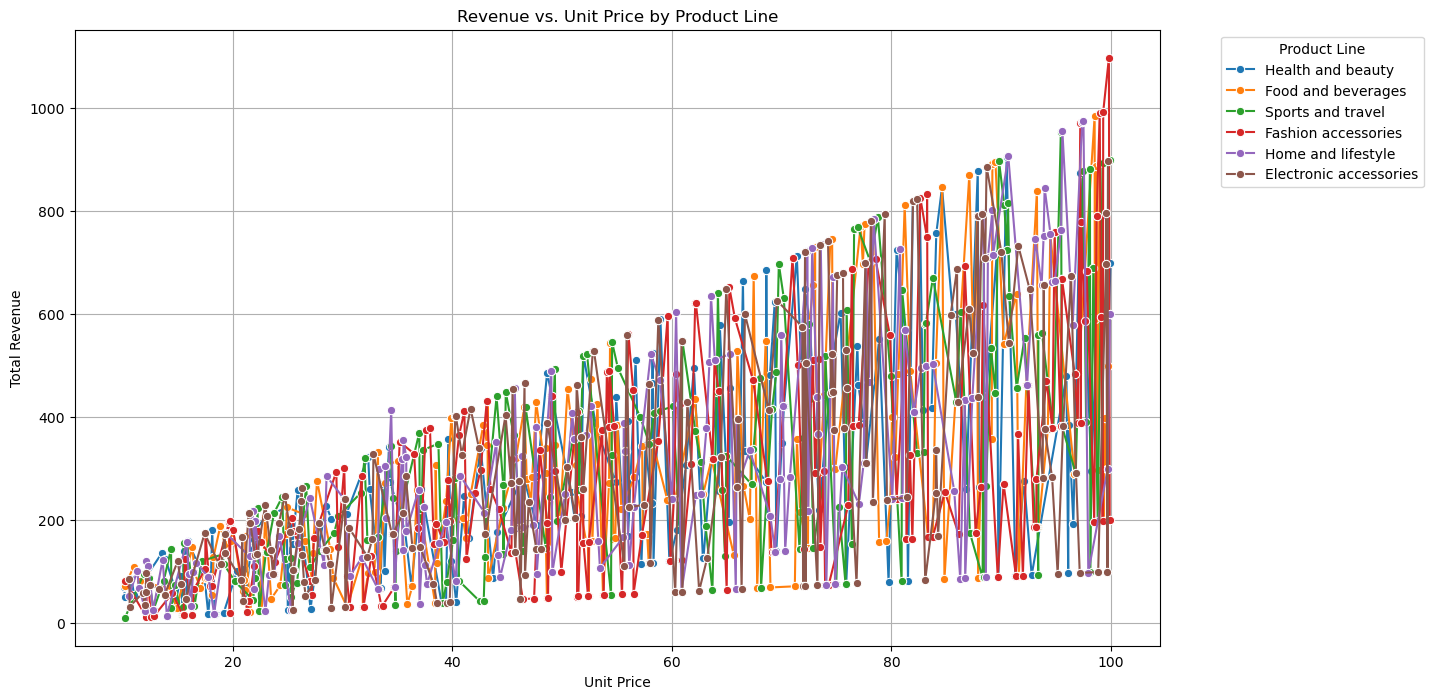

In [30]:
# Plotting the relationship between Unit price and Revenue
plt.figure(figsize=(14, 8))
sns.lineplot(x='Unit price', y='Revenue', hue='Product line', data=revenue_by_price, marker='o')
plt.title('Revenue vs. Unit Price by Product Line')
plt.xlabel('Unit Price')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.legend(title='Product Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [31]:
# Identifying optimal price points that maximize revenue
optimal_prices = revenue_by_price.loc[revenue_by_price.groupby('Product line')['Revenue'].idxmax()]
print("\nOptimal Pricing Points for Maximizing Revenue:")
print(optimal_prices[['Product line', 'Unit price', 'Revenue']])


Optimal Pricing Points for Maximizing Revenue:
               Product line  Unit price  Revenue
984  Electronic accessories       99.73   897.57
987     Fashion accessories       99.82  1098.02
959      Food and beverages       98.52   985.20
871       Health and beauty       90.50   905.00
949      Home and lifestyle       97.50   975.00
922       Sports and travel       95.44   954.40


### Anticipating customer needs

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

### Data Pre-processing for customer anticipation

In [35]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Ensure 'Quantity' is numeric
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data = data.dropna(subset=['Quantity'])

# Encode categorical variables
label_encoders = {}
for column in ['Product line', 'Customer type', 'Gender', 'Branch', 'City', 'Payment']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

#### Feature enginerring 

In [37]:
# Feature engineering: creating aggregate features
customer_features = data.groupby('Invoice ID').agg({
    'Quantity': 'sum',  # Total quantity purchased
    'Product line': 'nunique',  # Number of different product lines purchased
    'Unit price': 'mean',  # Average price of items purchased
    'Date': ['min', 'max'],  # First and last purchase date
    'cogs': 'sum',  # Total cost of goods sold
    'gross income': 'sum',  # Total gross income
}).reset_index()

In [38]:
customer_features.columns = ['Invoice ID', 'Total Quantity', 'Num Product Lines', 'Avg Unit Price', 'First Purchase', 'Last Purchase', 'Total COGS', 'Total Gross Income']

# Calculate the days since the first and last purchase
customer_features['First Purchase'] = (customer_features['First Purchase'] - customer_features['First Purchase'].min()).dt.days
customer_features['Last Purchase'] = (customer_features['Last Purchase'] - customer_features['Last Purchase'].min()).dt.days

# Prepare to predict for each product line
product_lines = label_encoders['Product line'].classes_

# Dictionary to store models and results for each product line
models = {}
results = {}

#### Training and Testing of the RandomForestClassifier model 

In [40]:
product_list=['Electronic accessories' ,'Fashion accessories', 'Food and beverages', 'Health and beauty', 'Home and lifestyle' ,'Sports and travel']

for product_line in product_lines:
    # Create a target variable for the current product line
    product_line_code = label_encoders['Product line'].transform([product_line])[0]
    data['Target'] = (data['Product line'] == product_line_code).astype(int)
    
    # Merge features with the target
    final_data = pd.merge(customer_features, data[['Invoice ID', 'Target']].drop_duplicates(), on='Invoice ID')
    
    # Split the data into training and testing sets
    X = final_data.drop(['Invoice ID', 'Target'], axis=1)
    y = final_data['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Build the predictive model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Store the model and results
    models[product_line] = model
    results[product_line] = {'Accuracy': accuracy, 'Report': report}
    
    # Print the results for the current product line
    for product in product_list:
        print(f"Results for product line '{product}':")
        product_list.pop(0)
        break
    
    
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    
    # Feature importance
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Feature Importances:\n", importance)
    print("\n")

Results for product line 'Electronic accessories':
Accuracy: 0.8133333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90       250
           1       0.12      0.02      0.03        50

    accuracy                           0.81       300
   macro avg       0.48      0.50      0.47       300
weighted avg       0.71      0.81      0.75       300

Feature Importances:
 Avg Unit Price        0.208228
Total Gross Income    0.207387
Total COGS            0.199798
Last Purchase         0.153016
First Purchase        0.150112
Total Quantity        0.081459
Num Product Lines     0.000000
dtype: float64


Results for product line 'Fashion accessories':
Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89       251
           1       0.21      0.06      0.10        49

    accuracy                           0.81       300
   macro

#### Example of Anticipating a customer need with our model

In [42]:
# Example: Predicting for a new customer for each product line
new_customer_data = {
    'Total Quantity': 50,
    'Num Product Lines': 3,
    'Avg Unit Price': 25.0,
    'First Purchase': 200,
    'Last Purchase': 50,
    'Total COGS': 1000,
    'Total Gross Income': 150
}

new_customer_df = pd.DataFrame([new_customer_data])

product_list=['Electronic accessories' ,'Fashion accessories', 'Food and beverages', 'Health and beauty', 'Home and lifestyle' ,'Sports and travel']

for product_line in product_lines:
    model = models[product_line]
    predicted_need = model.predict(new_customer_df)
    for product in product_list:
        print(f"Predicted need for product line '{product}': {predicted_need[0]}")
        product_list.pop(0)
        break

Predicted need for product line 'Electronic accessories': 0
Predicted need for product line 'Fashion accessories': 1
Predicted need for product line 'Food and beverages': 0
Predicted need for product line 'Health and beauty': 0
Predicted need for product line 'Home and lifestyle': 0
Predicted need for product line 'Sports and travel': 0


## Targeted promotions

In [44]:
product_list=['Electronic accessories' ,'Fashion accessories', 'Food and beverages', 'Health and beauty', 'Home and lifestyle' ,'Sports and travel']

new_customer_df = pd.DataFrame([new_customer_data])
i=0
for product_line in product_lines:
    model = models[product_line]
    predicted_need = model.predict(new_customer_df)
    if predicted_need[0] == 1:  # Target only if the customer is predicted to need this product line
        print(f"Target this customer with promotions for product line '{product_list[i]}'")

    i += 1

Target this customer with promotions for product line 'Fashion accessories'


#### Saving the model

In [46]:
# Save the models for later use (optional)
import joblib
for product_line in product_lines:
    joblib.dump(models[product_line], f'RandomForestClassifier_model_{product_line}.pkl')

## Making product recommendations

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

In [49]:
# Ensure 'Quantity' is numeric
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data = data.dropna(subset=['Quantity'])

# Encode categorical variables
label_encoders = {}
for column in ['Product line', 'Customer type', 'Gender', 'Branch', 'City', 'Payment']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [50]:
# Create a customer-product matrix
customer_product_matrix = data.pivot_table(index='Invoice ID', columns='Product line', values='Quantity', aggfunc='sum').fillna(0)

# Calculate the cosine similarity between products
product_similarity = cosine_similarity(customer_product_matrix.T)
product_similarity_df = pd.DataFrame(product_similarity, index=customer_product_matrix.columns, columns=customer_product_matrix.columns)

In [51]:
# Function to recommend products
def recommend_products(customer_id, num_recommendations=3):
    if customer_id not in customer_product_matrix.index:
        print("Customer not found.")
        return []
    
    # Get the customer's purchase history
    customer_purchases = customer_product_matrix.loc[customer_id]
    
    # Multiply the purchase history by the similarity matrix to get scores for each product
    recommendation_scores = np.dot(customer_purchases, product_similarity_df)
    
    # Convert the scores to a series
    recommendation_scores = pd.Series(recommendation_scores, index=product_similarity_df.index)
    
    # Filter out products the customer has already purchased
    recommendation_scores = recommendation_scores[customer_purchases == 0]
    
    # Get the top product recommendations
    recommended_products = recommendation_scores.sort_values(ascending=False).head(num_recommendations)
    
    return recommended_products

In [52]:
new_customer_data = {
    'Invoice ID' : 999-99-9999,
    'Total Quantity': 50,
    'Num Product Lines': 3,
    'Avg Unit Price': 25.0,
    'First Purchase': 200,
    'Last Purchase': 50,
    'Total COGS': 1000,
    'Total Gross Income': 150
}

new_customer_df = pd.DataFrame([new_customer_data])

In [53]:
# Example: Recommend products for a specific customer
customer_id = '727-02-1313' 
recommended_products = recommend_products(customer_id, num_recommendations=6)

if not recommended_products.empty:
    print(f"Recommended products for customer {customer_id}:")
    print(recommended_products)
else:
    print(f"No recommendations available for customer {customer_id}.")

Recommended products for customer 727-02-1313:
Product line
0    0.0
1    0.0
3    0.0
4    0.0
5    0.0
dtype: float64


## Demand forecasting

In [56]:
data = pd.read_csv('WalmartSalesData.csv')
data

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,2019-01-29,13:46:00,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,2019-03-02,17:16:00,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2019-02-09,13:22:00,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2019-02-22,15:33:00,Cash,65.82,4.761905,3.2910,4.1


In [58]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Ensure 'Quantity' is numeric
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data = data.dropna(subset=['Quantity'])

In [60]:
# Encode categorical variables
label_encoders = {}
for column in ['Product line', 'Customer type', 'Gender', 'Branch', 'City', 'Payment']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [62]:
# Aggregate data by month and product line
data['Month'] = data['Date'].dt.to_period('M')
monthly_data = data.groupby(['Month', 'Product line'])['Quantity'].sum().reset_index()

# Convert 'Month' to datetime
monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()

In [64]:
# Example: Demand forecasting for a specific product line
product_line = 'Electronic accessories'  
product_line_encoded = label_encoders['Product line'].transform([product_line])[0]
product_data = monthly_data[monthly_data['Product line'] == product_line_encoded]

In [66]:
product_data

,Month,Product line,Quantity
0,2019-01-01,0,333
6,2019-02-01,0,313
12,2019-03-01,0,325


Mean Absolute Error: 2.0000042444351607


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next v

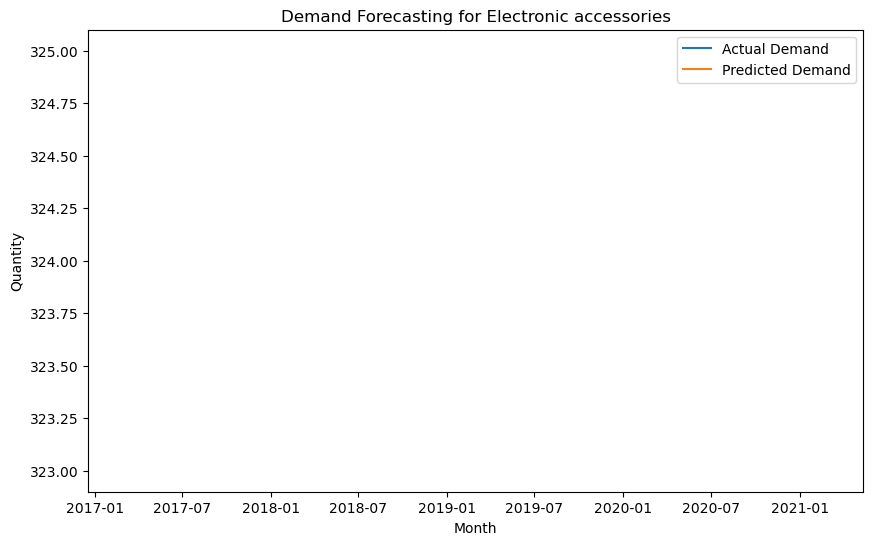

       Month  Predicted Demand
2 2019-04-30        322.999996
3 2019-05-31        322.999996
4 2019-06-30        322.999996
5 2019-07-31        322.999996
6 2019-08-31        322.999996
7 2019-09-30        322.999996


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/z6/r57ddz213j7gnxkkgzlfr3d00000gn/T/ipykernel_14290/140703690.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=test['Month'].max(), periods=future_periods + 1, freq='M')[1:]


In [68]:
# Check if there's enough data to proceed
if len(product_data) < 2:  # Adjust this threshold based on your data
    print("Insufficient data to fit the ARIMA model.")
else:
    # Train-test split
    train_size = int(len(product_data) * 0.8)
    train, test = product_data[:train_size], product_data[train_size:]

    # Fit the ARIMA model
    try:
        model = ARIMA(train['Quantity'], order=(0, 0, 0))
        model_fit = model.fit()

        # Make predictions
        predictions = model_fit.forecast(steps=len(test))

        # Evaluate the model
        mae = mean_absolute_error(test['Quantity'], predictions)
        print(f"Mean Absolute Error: {mae}")

        # Plot actual vs. predicted
        plt.figure(figsize=(10, 6))
        plt.plot(test['Month'], test['Quantity'], label='Actual Demand')
        plt.plot(test['Month'], predictions, label='Predicted Demand')
        plt.xlabel('Month')
        plt.ylabel('Quantity')
        plt.title(f'Demand Forecasting for {product_line}')
        plt.legend()
        plt.show()

        # Future Forecast
        # Forecast the next 6 months
        future_periods = 6
        future_predictions = model_fit.forecast(steps=future_periods)
        future_dates = pd.date_range(start=test['Month'].max(), periods=future_periods + 1, freq='M')[1:]

        # Show forecast
        future_forecast = pd.DataFrame({'Month': future_dates, 'Predicted Demand': future_predictions})
        print(future_forecast)

    except Exception as e:
        print(f"Error in ARIMA model: {e}")

In [70]:
label_encoders['Product line'].classes_

array(['Electronic accessories', 'Fashion accessories',
       'Food and beverages', 'Health and beauty', 'Home and lifestyle',
       'Sports and travel'], dtype=object)

Mean Absolute Error: 2.0000042444351607


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


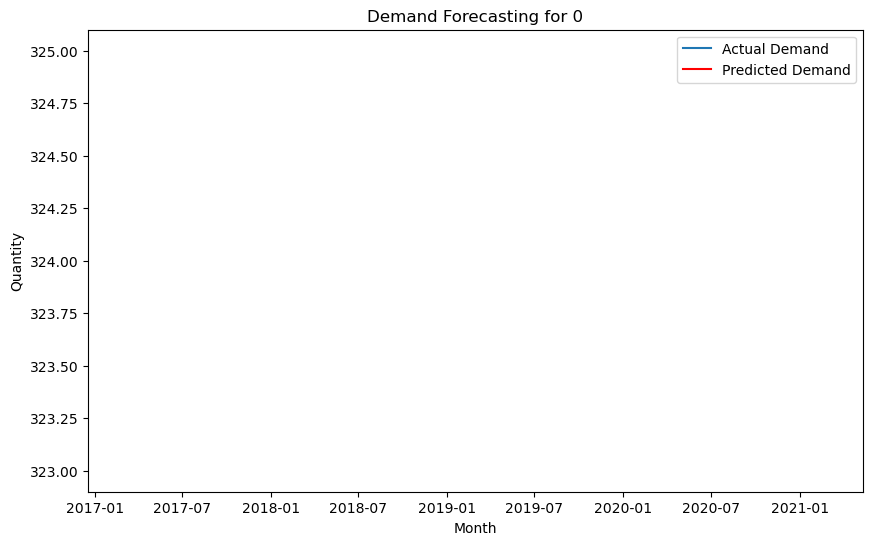

       Month  Predicted Demand
2 2019-04-30        322.999996
3 2019-05-31        322.999996
4 2019-06-30        322.999996
5 2019-07-31        322.999996
6 2019-08-31        322.999996
7 2019-09-30        322.999996


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/z6/r57ddz213j7gnxkkgzlfr3d00000gn/T/ipykernel_14290/2949884489.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=test.index.max(), periods=future_periods + 1, freq='M')[1:]


In [72]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Ensure 'Quantity' is numeric
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data = data.dropna(subset=['Quantity'])

# Encode categorical variables
label_encoders = {}
for column in ['Product line', 'Customer type', 'Gender', 'Branch', 'City', 'Payment']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Aggregate data by month and product line
data['Month'] = data['Date'].dt.to_period('M')
monthly_data = data.groupby(['Month', 'Product line'])['Quantity'].sum().reset_index()

# Convert 'Month' to datetime
monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()

# Example: Demand forecasting for a specific product line
product_line = 0  # Replace with actual product line name

# Check if the provided product line exists in the data
if product_line not in label_encoders['Product line'].classes_:
    raise ValueError(f"Product line '{product_line}' not found in the data.")

# Transform the product line to its encoded value
product_line_encoded = label_encoders['Product line'].transform([product_line])[0]

# Filter the data for the specific product line
product_data = monthly_data[monthly_data['Product line'] == product_line_encoded]

# Check if there's enough data to proceed
if len(product_data) < 2:  # Adjust this threshold based on your data
    print("Insufficient data to fit the ARIMA model.")
else:
    # Train-test split
    train_size = int(len(product_data) * 0.8)
    train, test = product_data[:train_size], product_data[train_size:]

    # Ensure index is datetime
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

    # Fit the ARIMA model
    try:
        model = ARIMA(train['Quantity'], order=(0, 0, 0))  # Adjust the order to prevent overfitting
        model_fit = model.fit()

        # Make predictions
        predictions = model_fit.forecast(steps=len(test))
        predictions.index = test.index  # Align prediction index with test data

        # Evaluate the model
        mae = mean_absolute_error(test['Quantity'], predictions)
        print(f"Mean Absolute Error: {mae}")

        # Plot actual vs. predicted
        plt.figure(figsize=(10, 6))
        plt.plot(test.index, test['Quantity'], label='Actual Demand')
        plt.plot(predictions.index, predictions, label='Predicted Demand', color='red')
        plt.xlabel('Month')
        plt.ylabel('Quantity')
        plt.title(f'Demand Forecasting for {product_line}')
        plt.legend()
        plt.show()

        # Future Forecast
        future_periods = 6
        future_predictions = model_fit.forecast(steps=future_periods)
        future_dates = pd.date_range(start=test.index.max(), periods=future_periods + 1, freq='M')[1:]

        # Show forecast
        future_forecast = pd.DataFrame({'Month': future_dates, 'Predicted Demand': future_predictions})
        print(future_forecast)

    except Exception as e:
        print(f"Error in ARIMA model: {e}")

## Search and discovery

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [76]:
# Example data (product name, description, etc.)
products = pd.DataFrame({
    'ProductID': [1, 2, 3, 4, 5],
    'ProductName': ['Laptop', 'Smartphone', 'Tablet', 'Headphones', 'Smartwatch'],
    'Description': [
        'High performance laptop with 16GB RAM',
        'Latest model smartphone with OLED display',
        'Portable tablet with high-resolution screen',
        'Noise-cancelling wireless headphones',
        'Smartwatch with heart rate monitor and GPS'
    ]
})

### Keyword Search

In [80]:
# Step 1: Keyword Search
def keyword_search(query, products_df):
    """Search products based on keywords."""
    query = query.lower()
    return products_df[products_df['ProductName'].str.contains(query, case=False) |
                       products_df['Description'].str.contains(query, case=False)]

In [82]:
# Example search query
query = "smart"
search_results = keyword_search(query, products)
print("Search Results:")
print(search_results[['ProductID', 'ProductName', 'Description']])

Search Results:
   ProductID ProductName                                 Description
1          2  Smartphone   Latest model smartphone with OLED display
4          5  Smartwatch  Smartwatch with heart rate monitor and GPS


### Similarity-Based Discovery

In [85]:
# Step 2: Similarity-Based Discovery
def discover_similar_products(product_id, products_df, top_n=3):
    """Find similar products based on descriptions."""
    # Vectorize the product descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(products_df['Description'])

    # Compute cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Get the index of the product
    product_idx = products_df.index[products_df['ProductID'] == product_id].tolist()[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[product_idx]))

    # Sort by similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N similar products (excluding the product itself)
    sim_scores = sim_scores[1:top_n + 1]

    # Get the indices of the top similar products
    similar_indices = [i[0] for i in sim_scores]

    return products_df.iloc[similar_indices]


In [87]:
# Example discovery query
product_id = 2  # Searching for products similar to 'Smartphone'
similar_products = discover_similar_products(product_id, products)
print("\nSimilar Products:")
print(similar_products[['ProductID', 'ProductName', 'Description']])


Similar Products:
   ProductID ProductName                                  Description
0          1      Laptop        High performance laptop with 16GB RAM
2          3      Tablet  Portable tablet with high-resolution screen
3          4  Headphones         Noise-cancelling wireless headphones
